In [2]:
import statsmodels.api as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import math
from scipy import stats
from sklearn.datasets import make_regression

# Contents

- [1. Simple linear regression](#1.-Simple-linear-regression) 
    - 1.1 SLR equations
    - 1.2 Python example
    - 1.3 Python Example: Packages to implement regression
    - 1.4 Regression assumptions
    
- [2. Multiple linear regression model](#2.-Multiple-linear-regression-model) 
    - 2.1 Review matrix differentiation
    - 2.2 Example: Calculating OLS using matrix algebra
    - 2.3 Projection matrices
    - 2.4 Goodness of fit
    - 2.5 Variance
          
- [3. Regression diagnostics](#3.-Regression-diagnostics) 
    - 3.1 Central moments
    - 3.2 Omitted variable bias
    - 3.3 Reverse causality
    - 3.4 Functional misspecification
    - 3.5 Testing for misspecification
    - 3.6 Serial correlation
    - 3.7 Homoskedasticity
    - 3.8 Perfect collinearity
    - 3.9 Normality
    - 3.10 F-statistic
- [4. Interpreting regression](#4.-Interpreting-regression) 
    - 4.1 Hypothesis testing in linear regression
    - 4.2 Dummy variables
    - 4.3 Lagged dependent variables
    - 4.4 Levels vs. differences regression
- [A. Appendix](#A.-Appendix) 
    - A.1 Degrees of freedom
    - A.2 Overfitting-model
    - A.3 Gauss-Markov Theorem proof: Matrix form
    - A.4 Visualize OLS: Geometric interpretaiton 


# References

- Cochrane, John H. ["Time series for macroeconomics and finance."](http://econ.lse.ac.uk/staff/wdenhaan/teach/cochrane.pdf) University of Chicago (2005): 1-136.


- Creel, Michael. [Econometrics](https://github.com/mcreel/Econometrics/blob/master/econometrics.pdf)


- Ferrell, Rebecca [CSSS508](http://rebeccaferrell.github.io/CSSS508/Homework/template-HW4-key.html)


- Hamilton, J. D. [Time series analysis.](https://www.amazon.com/Time-Analysis-James-Douglas-Hamilton/dp/0691042896) *Princeton University. (1994)*


- Lambert, Ben. [A graduate course in econometrics](https://www.youtube.com/playlist?list=PLwJRxp3blEvaxmHgI2iOzNP6KGLSyd4dz)


- Shi, Zhentao. [Lecture notes for Econ5121A: Econometric Theory and Applications.](https://github.com/zhentaoshi/Econ5121A)









# 1. Simple linear regression

## 1.1 SLR equations

$$y_t = \alpha + b_t x_t + u_t$$

$$\hat\beta = \frac{\sum(x_t-\bar x_t)(y_t-\bar y)}{\sum(x_t-\bar x)^2}=\frac{Cov(x_i,y_i)}{Var(x_i}\\
\hat\alpha = \bar y-\hat\beta \bar x$$

## 1.2 Python Example: Simple linear regression

#### 1.2.1. Generate random data & estimate beta by hand

In [2]:
np.random.seed(10)
n = 20 # sample size 
K = 2  # number of paramters
sim = np.hstack( ( np.ones( (n,1) ), stats.norm.rvs(  size = (n, K))) ) 
df = pd.DataFrame(sim, columns=['c','y','x'])
df['xt'] = (df.x-np.mean(df.x))
df['yt'] = (df.y-np.mean(df.y))
df['xt2'] = df.x**2
df['yt2'] = df.y**2
df['beta'] = sum(df.xt*df.yt)/sum(df.xt2)
df['alpha'] = np.mean(df.y)- (df.beta*np.mean(df.x)) #Also alpha
df['y_hat'] = df.alpha+df.x*df.beta
df['u_hat'] = df.y-df.alpha-(df.beta*df.x)
df['y_mean'] = np.mean(df.y)
df.head(2) 

,c,y,x,xt,yt,xt2,yt2,beta,alpha,y_hat,u_hat,y_mean
0,1.0,1.331587,0.715279,0.511383,1.191970,0.511624,1.773123,0.153198,0.10838,0.217960,1.113627,0.139617
1,1.0,-1.545400,-0.008384,-0.212280,-1.685017,0.000070,2.388262,0.153198,0.10838,0.107096,-1.652496,0.139617


#### 1.2.2. Estimate beta with statsmodels

In [3]:
ols_single = sm.OLS(df.y,df[['c','x']]).fit()

#### 1.2.3. Compare beta of 1. & 2.

In [4]:
beta = sum(df.xt*df.yt)/sum(df.xt2)
alpha = np.mean(df.y)- (beta*np.mean(df.x))
print("Beta_hand: {:.4f}, Alpha_hand: {:.4f}".format(beta, alpha))
print("Beta_model: {:.4f}, Alpha_model: {:.4f}".format(ols_single .params[1], ols_single.params[0]))

Beta_hand: 0.1532, Alpha_hand: 0.1084
Beta_model: 0.1598, Alpha_model: 0.1070


#### 1.2.4. Python example: Graph yhat (Best fit line) $R^2$, TSS, RSS, ESS

- See section [2.4 Goodness of fit](#2.4-Goodness-of-fit) for further explanation of $R^2$, TSS, RSS, ESS

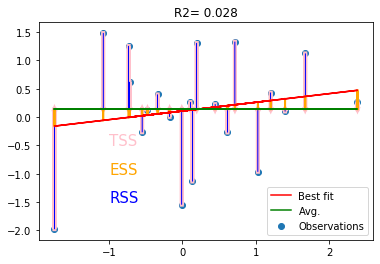

In [5]:
x=df.x.values
y=df.y.values
best_fit = df.y_hat.values
tss_graph = -(df.y-df.y_mean)
ess_graph = -(df.y_hat-df.y_mean)
rss_graph = -(df.y-df.y_hat)

ess = sum((df.y_hat-df.y_mean)**2)
rss = sum((df.y-df.y_hat)**2)
tss = sum((df.y-df.y_mean)**2)
r2= 1-rss/tss

ax = plt.scatter(df.x,df.y, label=None)
ax =plt.plot(df.x, df.y_hat, color='red')
ax =plt.plot(df.x, df.y_mean, color='green', label='Y_mean')

for i in range(0,len(df.x)):
    plt.arrow(x[i], y[i], 0, tss_graph[i], head_width=None, head_length=None, linewidth=4, color='pink', label='TSS')

for i in range(0,len(df.x)):
    plt.arrow(x[i], y[i], 0, rss_graph[i], head_width=None, head_length=None, linewidth=.5, color='blue', label='RSS')

for i in range(0,len(df.x)):
    plt.arrow(x[i], best_fit[i], 0, ess_graph[i], head_width=None, head_length=None, linewidth=2, color='orange', label='ESS')

plt.annotate("TSS", xy=(-1, -.5), xytext=(-1, -.5), size=15,color='pink')
plt.annotate("RSS", xy=(-1, -1.5), xytext=(-1, -1.5), size=15,color='blue')
plt.annotate("ESS", xy=(-1, -1), xytext=(-1, -1), size=15,color='orange')


plt.legend(['Best fit', 'Avg.','Observations'])

    
    
plt.title('R2= {:.3f}'.format(r2))
plt.show()

## 1.3 Python Example: Packages to implement regression
1. sm.OLS(y,x_c).fit()
2. np.polyfit(x,y, deg=1)
3. stats.linregress(x,y)

In [6]:
#Stats models
print('sm.OLS(y,x).fit()')
ols_single = sm.OLS(df.y,df[['c','x']]).fit()
print('Intercept: {:.3f}'.format(ols_single.params[0]), 'Slope: {:.4f}'.format(ols_single.params[1]))
print('Np.polyfit(x,y)')
# np.polyfit
sentence = 'Intercept:{}, Slope:{}'.format(round(np.polyfit(df.x,df.y, deg=1)[1],4), round(np.polyfit(df.x,df.y, deg=1)[0],4))
print(sentence)
print('stats.linregress(x,y)')
#stats.linregress
print('Intercept: {:.3f}'.format(stats.linregress(df.x,df.y)[1]), 'Slope: {:.4f}'.format(stats.linregress(df.x,df.y)[0]))

sm.OLS(y,x).fit()
Intercept: 0.107 Slope: 0.1598
Np.polyfit(x,y)
Intercept:0.107, Slope:0.1598
stats.linregress(x,y)
Intercept: 0.107 Slope: 0.1598


## 1.4 Regression Assumptions 

#### Independently and identically distributed errors:

$$\epsilon\sim IID(0,\sigma^{2}I_{n})$$


$\varepsilon$ is jointly distributed IID. This implies the following two properties:

#### Homoscedastic errors:
$$V(\varepsilon_{t})=\sigma_{0}^{2},\forall t$$

#### Nonautocorrelated errors:

$$E(\varepsilon_{t}\epsilon_{s})=0,\forall t\neq s$$

Optionally, we will sometimes assume that the errors are normally distributed.

#### Normally distributed errors:
$$\epsilon\sim N(0,\sigma^{2}I_{n})$$

Reference: Latex code via Creel, Michael.

# 2. Multiple linear regression model

## 2.1.1 Review matrix differentiation:

$x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} $
$A = \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix} $

$Q = \underset{1x2}{x\prime} \ \ \ \underset{2x2}{A} \ \ \ \underset{2x1}{x}$

$=  \begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix} a_{11}x_1 + a_{12}x_2 \\ a_{12}x_1 + a_{22}x_2 \end{bmatrix} $

$Q= a_{11} x_1^2 + 2a_{12} x_1 x_2 + a_{22} x_2^2$

Differentiate x:

$\frac{dQ}{dx}= \begin{bmatrix} dQ/dx_1 \\ dQ/dx_2 \end{bmatrix} =  \begin{bmatrix} 2a_{11}x_1 + 2a_{12}x_2 \\ 2a_{12}x_1 + 2a_{22}x_2 \end{bmatrix} \equiv 2AX$


Differentiate $x\prime$:

$\frac{dQ}{dx\prime}= \begin{bmatrix} dQ/dx_1 & dQ/dx_2 \end{bmatrix} = 2X\prime A\prime = 2X\prime A$

## 2.1.2 Multivariate OLS
$y_t = X_t\prime \beta + \mu_t$

Where $\beta$ minimizes the residuals sum of squares (RSS):

RSS $\equiv \sum_{T=1}^T (y_t - x_t\prime \beta)^2$

OLS estimate $\beta$:

$$\beta = [\sum x_t x_t\prime]^{-1} [\sum x_t y_t]$$

Where:

$
\underset{Tx1}{y} \equiv \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_T \end{bmatrix}
\underset{TxK}{x} \equiv \begin{bmatrix} x_1\prime \\ x_2\prime \\ \vdots \\ x_T\prime \end{bmatrix}
\underset{Tx1}{u} \equiv \begin{bmatrix} u_1 \\ u_2 \\ \vdots \\ u_T \end{bmatrix}
$

So rewritten OLS:

$b = \Bigg\{\begin{bmatrix} x_1 \ x_2 \ \vdots \ x_T \end{bmatrix} 
\begin{bmatrix} x_1\prime \\ x_2\prime \\ \vdots \\ x_T\prime \end{bmatrix}
\Bigg\}^{-1} \Bigg\{\begin{bmatrix} x_1 \ x_2 \ \vdots \ x_T \end{bmatrix} 
\begin{bmatrix} x_1\prime \\ x_2\prime \\ \vdots \\ x_T\prime \end{bmatrix}
\Bigg\}$

$\equiv (X\prime X)^{-1}X\prime y$

## 2.1.3 Derive OLS in matrix form
#### Residual vector:
Multivariate:
$S = \hat\mu\prime \hat\mu = u_1^2 + u_2^2 + \cdots + u_n^2 $

$y= X\hat\beta + \hat\mu$ 


$\equiv \hat \mu = y-x \hat\beta$

$S = (y-x \hat\beta)\prime (y-x \hat\beta)$

$S = (y\prime-x\prime \hat\beta\prime) (y-x \hat\beta)$

$S = y\prime y -y\prime x \hat\beta - \hat\beta\prime x\prime y + \hat\beta\prime x\prime x \hat\beta$

#### Derive residual vector:

$\frac{dS}{d\hat\beta}= -x\prime y - x\prime y +2 x\prime x \hat\beta = 0$

=$\frac{dS}{d\hat\beta}= -2x\prime y +2 x\prime x \hat\beta$

Set to 0:

$-2x\prime y +2 x\prime x \hat\beta = 0$

$ x\prime x \hat\beta = x\prime y $

Use identity matrix

$ (x\prime x)^{-1}x\prime x \hat\beta = (x\prime x)^{-1}x\prime y $

### $\equiv  \hat\beta = (x\prime x)^{-1}x\prime y $

#### Showing orthogonality:

$-2x\prime y +2 x\prime x \hat\beta = 0$
$-2x\prime y +2 x\prime x \hat\beta = 0$


Reference: Lambert, Ben

## 2.2 Example: Calculating OLS using matrix algebra

- 2.2.1 Generating random X,Y data
- 2.2.2 Calculating $\beta$ by hand using matrix algebra
- 2.2.3 Calculating $\beta$ using statsmodels package
- 2.2.4 Compare hand and statsmodels

#### 2.2.1 Generate random data X,Y

In [7]:
np.random.seed(1)
n = 20 # sample size 
K = 2  # number of paramters
X = np.hstack( ( np.ones( (n,1) ), stats.norm.rvs(  size = (n, K))) )  # Indpendent variables
Y = stats.norm.rvs(  size = (20, 1)) # Dependent Variables

#### 2.2.2 Calculate  $\hat{\beta}$ by hand: 

Remember $\hat{\beta}: (X' X)^{-1} X'Y$

In [8]:
bhat = np.linalg.inv(X.T@X)@(X.T@Y)
intercept = bhat[0]
bhat1 = bhat[1]
bhat2 = bhat[2]

#### 2.2.3 Calculate $\hat \beta$ by statsmodels' OLS package

In [9]:
#Create dataframe with Y & X

yx = pd.DataFrame(np.concatenate([Y,X], axis=1))
yx.columns = ['Y', 'Constant', 'X1', 'X2']

# Import ols from statsmodels, and fit a model to the data
from statsmodels.formula.api import ols
ols_multi = ols(formula="Y ~ X1+X2", data=yx)
ols_multi = ols_multi.fit()

# Extract the model parameter values, and assign them to a0, a1
a0 = ols_multi.params['Intercept']
a1 = ols_multi.params['X1']
a2 = ols_multi.params['X2']

#### 2.2.4 Compare $\hat \beta$ hand (2.2.2) and stats model (2.2.3)

- Note: The results should be equal

In [10]:
print('Calculated by hand:')
print('Intercept = {:.4f}'.format(float(intercept)))
print('bhat1= {:.4f} '.format(float(bhat1)))
print('bhat2= {:.4f} '.format(float(bhat2)))
print('')
print('Calculated using OLS:')
print( "Intercept  = {:0.4f}".format(a0) )
print( "bhat1 = {:0.4f}".format(a1) )
print( "bhat2 = {:0.4f}".format(a2) )

Calculated by hand:
Intercept = 0.2859
bhat1= 0.1272 
bhat2= 0.2650 

Calculated using OLS:
Intercept  = 0.2859
bhat1 = 0.1272
bhat2 = 0.2650


#### 2.2.5 Calculate $\hat{e}$:
$\hat{e} = Y - X' \hat{\beta}$. 

Demonstrate that $\hat{e}$ is orthogonal to X.T: 

Note: The result should be close to zero


In [11]:
ehat = Y -X@bhat
print(X.T @ ehat)

[[ 1.47104551e-15]
 [-2.58973139e-17]
 [ 2.08256193e-16]]


#### 2.2.6 Calculate $\hat y$:
$\hat y= \hat \beta X $

- Note: The results should be equal

In [12]:
yhat = X@bhat

print('Comparing yhat from hand calculation and statsmodels:')
print((np.hstack((yhat, ols_multi.predict().reshape(-1,1) ))[:1]))

Comparing yhat from hand calculation and statsmodels:
[[0.33036448 0.33036448]]


## 2.3 Projection matrices

- 2.3.1 Explanation
- 2.3.2 Calculate from example
- 2.3.3 Show that $\hat{y} = P_x Y +M_x Y$
- 2.3.4 Show that $\hat{u} =M_y $

### 2.3.1 Explanation of projection matrices

$X \hat{\beta}$ is the projection of y on the span of X

The matrix that projects y onto the span of X is known as $P_x$:

$P_x = X(X' X)^{-1} X' \tag{Eq 1}$ 

$\hat{e}$ is the projection of y onto the N-K dimensional space orthogonal to the span of X:


$\hat{e} = y -x\hat{\beta} = y- X(X' X)^{-1} X'y = [I_n - X(X' X)^{-1} X']y \tag{Eq 2}$ 

Thus the matrix that projects y onto the space orthogonal to the span of x is $M_x$:


$M_x = I_n - X(X' X)^{-1} X' = I_n-P_x \tag{Eq 3}$ 

Substituting in Eq 3 into Eq 2:

$ \hat{e} = M_x Y \tag{Eq 4}$ 

With MX and PX we can now substitute back into our original equation $y=X\hat{\beta}+\hat{e}$

$ y = P_x Y +M_x Y  \tag{Eq 5}$ 

 #### Summing up the above:
 
 
Vector fitted values:
$P_xY =X\hat{\beta} = \hat{y}$

Vector of Resduals:
$M_xY = y-\hat{y} ==\hat{u}$

$M_xY \perp P_pY$

This means that Y can be decomposed into two orthogonal vectors Py and My where the first is y in colspace x and the second represents the residual


Refrence: Latex code via Shi, Zhentao. [Lecture notes for Econ5121A: Econometric Theory and Applications.](https://github.com/zhentaoshi/Econ5121A)

### 2.3.1.1 Visualization of projection matrices

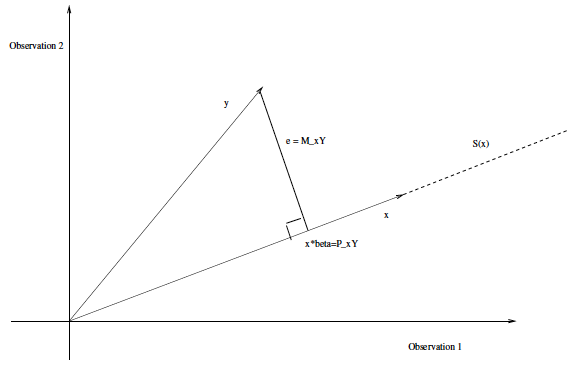

### 2.3.2 Calculate from example

##### The matrix that projects onto y onto the span of X: $P_X = (X' X)^{-1} X'Y$

In [13]:
PX = X @ np.linalg.solve( X.T @ X, X.T )
Py = PX@Y

In [14]:
PX[0]

array([ 0.16233504, -0.02619771,  0.06982499,  0.16989827,  0.05895378,
        0.12402409,  0.00281751,  0.11283674,  0.00698775,  0.04990676,
       -0.03643578,  0.12066834,  0.1003826 ,  0.01015834,  0.02298426,
       -0.02839111, -0.03566013, -0.02012924, -0.05335671,  0.18839222])

##### The matrix that projects y onto the space orthogonal to the span of X: $M_x$

In [15]:
MX = np.diag( np.ones(n) ) - PX
My = MX@Y

In [16]:
MX[0]

array([ 0.83766496,  0.02619771, -0.06982499, -0.16989827, -0.05895378,
       -0.12402409, -0.00281751, -0.11283674, -0.00698775, -0.04990676,
        0.03643578, -0.12066834, -0.1003826 , -0.01015834, -0.02298426,
        0.02839111,  0.03566013,  0.02012924,  0.05335671, -0.18839222])

### 2.3.3 Show that $y = P_x Y +M_x Y$

- Note: The results should be equal

In [17]:
print(np.hstack( (Y , Py+My))[:2])

[[-0.19183555 -0.19183555]
 [-0.88762896 -0.88762896]]


### 2.3.4 Show that $\hat u = M_y$

- Note: The results should be equal

In [18]:
print(np.hstack( (ehat , My))[:2])

[[-0.52220003 -0.52220003]
 [-0.8219903  -0.8219903 ]]


## 2.4 Goodness of fit 

#### Also known as $R^2$

- $\underline{Total}\text{sum of squares}=TSS=||y||^2 = \sum(y_i-\bar y)^2$
- $\underline{Residual}\text{sum of squares}=RSS=||My||^2=\sum(y_i-\hat y)^2$
- $\underline{Explained} \text{sum of squares}=ESS=||Py||^2=\sum(\hat y_i-\bar y)^2$

#### TSS = ESS+RSS

$ESS = TSS-RSS$

#### $R^2$
$R^2 = \frac{ESS}{TSS}\\
R^2 = 1-\frac{ess}{tss}$ 

#### Adjusted $R^2$  ($\bar{R}^2$)

$$\bar{R}^2= 1-\frac{(1-r^2)(N-1)}{N-K-1}\\
N\geq K$$

- If $K \uparrow$
    - $(N-K-1) \downarrow$
    - $\bar{R}^2 \downarrow$
    
- R-squared cannot fall when adding an additional regressor, however Adjusted R-square can

### 2.4.1 Calculate RSS

- Using Matrix form
- Using ehat

In [20]:
my_rss = sum(My**2) #Matrix form
print('Calculating RSS--Matrix MY: {:.3f}'.format(int(my_rss)))
ehat_rss = sum(ehat**2) # ehat
print('Calculating RSS using ehat: {:.3f}'.format(int(ehat_rss)))

Calculating RSS--Matrix MY: 12.000
Calculating RSS using ehat: 12.000


### 2.4.2 Calculate TSS

In [21]:
tss= sum((Y-np.mean(Y))**2)
print('TSS :{:.4f}'.format(float(tss)))

TSS :13.1303


### 2.4.3 Calculate $R^2$

In [22]:
rsq_hand = (1-(my_rss/tss))
print('R-squared by hand:{:.4f}'.format(float(rsq_hand)))
print('R-squared from stats-model:{:.4f}'.format(ols_multi.rsquared))

R-squared by hand:0.0756
R-squared from stats-model:0.0756


## 2.5 Variance

### 2.5.1 Covariance of a random vector

- Expectation of some constant matrix A * random vector X:

$E[AX] = AE[X]$

- Variance-covariance matrix:

Cannot define variance of random vector as a vector instead we define it as a matrix:

$var(x)$ = $\begin{bmatrix} var(x_1) & cov(x_1, x_2) & \cdots & cov(x_{11}x_n) \\ cov(x_2, x_1)& var(x_2) & \cdots & \vdots \\ cov(x_n x_1) \cdots & \cdots & \cdots &var(x_N)\end{bmatrix} $

#### 2.5.1.1 Proof of variance-covariance matrix:

$Var(X) = E[(x - \mu)(x - \mu)^T] \\
= E[\begin{bmatrix} x_1-\mu_1 \\ x_2-\mu_2 \\ \vdots \\ x_n-\mu_n \end{bmatrix}- \begin{bmatrix} x_1-\mu_1 & x_2-\mu_2 & \vdots & x_n-\mu_n \end{bmatrix}]\\
= \begin{bmatrix} (x_1-\mu_1)^2 & (x_1-\mu_1) & \cdots \\ 
\cdots & (x_2-\mu_2)^2 & \cdots \end{bmatrix}$


#### 2.5.1.2 Expectations and variance of a random vector

Var$(AX) = E[(Ax - A \mu)(Ax - A \mu)^T] $

$= E[(A(x - \mu)(x - \mu)^T A^T] $

$= A E[(x - \mu)(x - \mu)^T ]A^T $

= $A var(x) A^T $


#### 2.5.1.3 Unbiased LS estimators

$\hat\beta = (x\prime x)^{-1}x\prime y$

Plug in: $y = x\beta + \mu$

$\hat\beta = (x\prime x)^{-1}x\prime x \beta+ (x\prime x)^{-1}x\prime u\\
\hat\beta = \beta+ (x\prime x)^{-1}x\prime u\\
E[\hat\beta] = \beta+ (x\prime x)^{-1}x\prime \ E[u]\\
E[\hat\beta] = \beta$

#### 2.5.1.4 Equation for general variance
In general: Stochastic matrix A, non-stochastic y

- Find the variance of LS estimator $\hat\beta$
- Non-stochastic A, Stochastic Y

Var$(AY)$ = $A$ Var$(Y)A\prime$
- $A = (x\prime x)^-1$

$Var(\hat\beta_{ls}) = (x\prime x)^{-1} x\prime \ \ var(y) \ \ x(x\prime x)^{-1} \tag{1}$

Substitute $Var(Y) = \sigma^2 I$ into equation 1

$Var(\hat\beta_{ls}) = (x\prime x)^{-1} x\prime \ \ \sigma^2 I\ \ x(x\prime x)^{-1} \tag{2}$

$Var(\hat\beta_{ls}) =\sigma^2 (x\prime x)^{-1} \tag{3}$

- Equation 3 is the variance of least square estimator under the assumption of non-serial correlation and homoskedasticity

#### 2.5.1.5 Standard error of (variance) $\hat\beta$
 Estimator for the population error variance

#### Population:
$y=\alpha+\beta x+u, u-N(x,\sigma^2)\\
var(u)=E[(u-E(u))^2]=E[u^2]=\sigma^2$

#### Sample:
$y=\alpha+\beta x+u\\
\tilde\sigma^2=\frac{1}{N}\sum^{u}_{i=1}\hat u_i^2\\
=\frac{1}{N}[\hat u_1^2+\hat u_2^2+\hat u_{N-1}^2+\hat u_{N}^2]$

Where Variance of $\hat u_{N-1}^2+\hat u_{N}^2=0$ because of degrees of freedom


Thus considering degrees of freedom our S.E of $\hat\beta$:
$$\hat\sigma^2=\frac{1}{N-K}\sum^{N}_{i=1}\hat u_i^2$$

Estimated variance calculated in STATA and eviews:

$$Var(\hat\beta|x_i)= \frac{\frac{1}{N-K}\sum^{N}_{i=1}\hat u_i^2}{\sum(x_i-\bar{x})^2}\\
\text{Standard error:}=\sqrt{\frac{\frac{1}{N-K}\sum^{N}_{i=1}\hat u_i^2}{\sum(x_i-\bar{x})^2}}$$


Reference: Lambart, Ben

#### 2.5.1.5 Python Example:  Standard error of (variance) 

In [36]:
x, y = make_regression(n_samples=100, n_features=1, noise=1)
x_c = sm.add_constant(x)
results = sm.OLS(y,x_c).fit()

#Uhat calculation is correct because:
#sum(results.resid**2)==sum((y-results.predict())**2)
uhat = sum((y-results.predict())**2)
sxx= sum((x-np.mean(x))**2)
DF_correction = (1)/(len(x-1))
print(math.sqrt((DF_correction*uhat)/(sxx)))
print(results.bse[1])

0.10329300567626208
0.10434169251832211


### 2.5.2 Python example: Calculate variance using matrices

Reference: Example via Ferrell, Rebecca [CSSS508]

$$\hat{\sigma}^2 = \frac{(\mathbf{y} - \mathbf{X} \cdot \hat{\mathbf{\beta}})^T \cdot (\mathbf{y} - \mathbf{X} \cdot \hat{\mathbf{\beta}})}{n - p - 1}= \frac{\hat e^{T}\hat e}{n - p - 1}$$

$Var(\hat\beta)= \sigma^2 (x\prime x)^{-1}$


### 2.5.2.1 Generate data and calculate beta hat

In [37]:
# Generate X, Y data.
np.random.seed(1)
n = 20 # sample size 
K = 2  # number of paramters
X = np.hstack( ( np.ones( (n,1) ), stats.norm.rvs(  size = (n, K))) )  # Indpendent variables
Y = stats.norm.rvs(  size = (20, 1)) # Dependent Variables
# Calculate regression estimators (beta hat)
bhat = np.linalg.inv(X.T@X)@(X.T@Y)
result= sm.OLS(Y,X).fit()

### 2.5.2.2 Generate Variance-Covariance Matrix

In [38]:
ehat = Y -X@bhat
sigma_hat = ehat.T@ehat/(len(X-2))
cov = np.linalg.inv(X.T@X)
beta_covar = sigma_hat*cov
print('Covariance Matrixs')
print(beta_covar)
print('')
print(sm.OLS(Y,X).fit().cov_params())

Covariance Matrixs
[[ 0.03804739 -0.00388082  0.01575351]
 [-0.00388082  0.03882906  0.01349301]
 [ 0.01575351  0.01349301  0.04466534]]

[[ 0.04476163 -0.00456568  0.01853354]
 [-0.00456568  0.04568124  0.01587413]
 [ 0.01853354  0.01587413  0.05254746]]


### 2.5.2.3 Calculate S.E. of estimators

In [44]:
print('S.E. by hand:')
print(np.sqrt(np.diag(beta_covar)))
print('SE. by statsmodels library:')
print(sm.OLS(Y,X).fit().bse)

S.E. by hand:
[0.19505739 0.19705089 0.21134176]
SE. by statsmodels library:
[0.21156944 0.2137317  0.22923233]


### 2.5.3 Variance with heteroscedasticity

$Var(\beta|x_i)=\sigma^2_i$

Robust S.E. of $\hat\beta$(White s.e.):
$$Var(\hat\beta|x_i)=\frac{\sum(x_i-\bar x) \hat u_i^2}{{ssx}^2}$$

### 2.5.4 Variance with serial correlation

$cov(u_t, u_{t+j})= \rho^j\sigma^2$ AR(1) process

$$Var(\hat\beta|x_t)=\frac{\sum(x_i-\bar x) u_t}{{ssx}^2}\\
= \frac{\sigma^2}{ssx}+\frac{2\sum^{T-1}_{t=1}\sum^{T-t}_{j=1}x_tx_{t+j}\rho^j}{{ssx}^2} $$

- Assume $\bar{x}=0, \hat{u}=0$ 

# 3. Regression diagnostics

## 3.1 Central moments

### Expectation

Value we expect to get if we repeat process and average 

- 1st moment

$$E[x] = \int^{\infty}_{\infty}xf_xdx$$

- 2nd moment

$$E[x^2] = \int^{\infty}_{\infty}x^2f_xdx$$

### Variance (2nd central moment):
$$\mu_2= E[(x-\bar x)^2]$$

### Skewness (3rd central moment):
$$\mu_3= E[(x-\bar x)^3]\\\
\text{Skewnewss} = \frac{\mu_3}{(\sigma^2)^{3/2}}$$

- Postive skew leans right

### Kurtosis (4th central moment):
$$\mu_4= [(x-\bar x)^4]$$

- Divide by the variance squared subtracted by 3:

$$\text{Kurtosis}=\gamma = \frac{\mu_4}{\sigma_4}-3$$
$$\gamma>0 \ \ \text{Fatter tails than normal distribution}\\
\gamma<0 \ \ \text{Thinner tails than normal distribution}$$

### 3.1.1 Python Example: Central moments

In [46]:
sample = np.random.normal(loc=0, scale=3, size=100000)
def moments(sample):
    mean = np.mean(sample)
    print('Mean: {:.4f}'.format(mean))
    variance = sum((sample-mean)**2)/len(sample)
    print("Variance:{:.3f}".format(variance))
    std= math.sqrt(np.var(sample))
    print("Standard deviation:{:.3f}".format(std))
    skewness1 = sum((sample-mean)**3)/len(sample)
    skewness2 = skewness1/variance**(3/2)
    print("Skewness:{:.4f}".format(skewness2))
    kurtosis1 = sum((sample-mean)**4)/len(sample)
    kurtosis2 = (kurtosis1/variance**2)-3
    print("Kurtosis:{:.4f}".format(kurtosis2))
moments(sample)

Mean: 0.0113
Variance:8.948
Standard deviation:2.991
Skewness:0.0081
Kurtosis:-0.0158


## 3.2 Omitted variable bias


#### Example 1:
Test scores = $\alpha + \beta\text{class_size}+u$
   - We would expect that other factors are important in determining test scores other than class size so our error term does not equal zero
   - $E[u|\text{class_size}]\neq0$


#### Example 2:
$\text{wages}= \alpha + \beta_1 \text{education}+\beta_2\text{ability}+u$
   - $E[u|\text{education}]\neq0$
   - $Cov[\text{ability}|\text{education}]\neq0$

### Example proof:
$\text{wages}_i= \alpha + \beta_1 \text{edu}_i+u_i$
#### $$\hat\beta_1=\beta_1 + \frac{\sum(edu_i - \bar edu)u_i}{\sum(edu_i-\bar{edu})^2}$$

$\text{wages}_i= \alpha + \beta_1 \text{edu}_i+\beta_2\text{inate ability_i}_i+v_i$

$$\beta_1+ \frac{\sum(edu_i - \bar edu)(\beta_2ability+v_i)}{\sum(edu_i-\bar{edu})^2}$$

$$E[\hat\beta_1] +\frac{\beta_2\sum E\sum(edu_i - \bar edu)(ability_i)}{\sum(edu_i-\bar edu)^2}\\
E[\hat\beta_1]=\beta_1+\beta_2\text{bias}^2\\
E[\hat\beta_1]>\beta_1$$


## 3.3 Reverse causality

Endogenity:
$E[u_i|x_i]\neq 0$

#### Example:
$\text{violence}_i=\alpha+\beta_1\text{Development spending}_i+u_i$

$\hat\beta_{OLS}$ will produce upward estimations of development aid on violence.

- Regions which have higher levels of violence tend to recieve more development aid. 
- At first glance it could appear that there is a positive relationship between violence and development aid.
- This is an example of reverse casuality


### Example: $E[u_i|x_i]$


$\text{HDI}=\alpha+\beta_i\text{civil war}+u_i\\
\text{civil war}=\delta+\gamma\text{HDI}+v_i$

And it is likely that $Cov(\text{civil war}+u_i)\neq0$

$Cov(u, \text{civil war}= \gamma Cov(u, \delta+\text{HDI}+v_i)\\
=\gamma cov(u, \text{HDI})\\
=\gamma cov(u, \alpha+\beta\text{Civil war}+u\\
= \gamma var(u)\neq 0$



## 3.4 Functional misspecification

$\text{wages}= \alpha + \beta_1 \text{education}+\beta_2\text{Age}^2+u\\
\beta_1>0,\beta_2<0$

Reference: Lambert, Ben

### 3.4.1 Python example: Functional misspecification graph

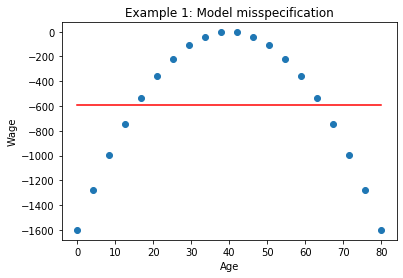

In [41]:
x = np.linspace(0, 80, 20)
y = -(x-40)**2

#User created graph function
def graph_reg(x,y):
    intercept = np.polyfit(x,y, deg=1)[1]
    slope = np.polyfit(x,y, deg=1)[0]
    best_fit = intercept+(slope*x)
    plt.scatter(x,y)
    plt.plot(x, best_fit, color='red')

#Using user created function to graph regression
graph_reg(x,y)
plt.ylabel('Wage')
plt.xlabel('Age')
plt.title('Example 1: Model misspecification')
plt.show()

### 3.4.2 Python example: Functional misspecification graph

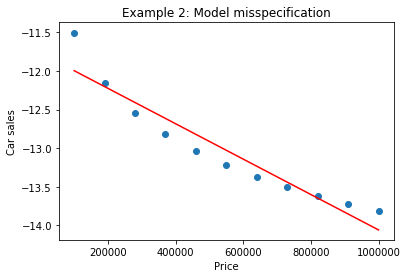

In [42]:
x = np.linspace(1, 10, 11)*100000
y = -np.log(x)
#Using user created function to graph regression
graph_reg(x,y)
plt.ylabel('Car sales')
plt.xlabel('Price')
plt.title('Example 2: Model misspecification')
plt.show()

## 3.5 Testing for misspecification

### Ramsey (RESET) test


$$y_i=\hat\alpha +\hat\beta_1+\hat\beta_2x_i+\hat\beta_p x_{pi}\\
y_i=\alpha+\beta_1x_{1i}+\cdots+\beta_px_{pi}+\gamma_1\hat y_i^2 +\gamma_2\hat y_i^3
\\\text{F-test}: H_0: \gamma_1=\gamma_2=0$$

- If our model is correctly specified T-test of $\gamma_1$ should not be rejected
    - It would not be necessary to include quadratic terms in our model
- We can also run an F-test $H_0: \gamma_1=\gamma_2=0$
    - If we reject the null then there is functional misspecfication 



## 3.6 Serial correlation

$cov(u_i, u_s)\neq0 \ \ \ i\neq s$

#### Serial correlation occurs when:

- Important variable is omitted
- Functional misspecification
- Measurement error in independent variable

#### Serial corrleation can also occur when our errors are clustered:

$y_{ig} = \alpha+\beta\text{Class size}_g + \varepsilon_{ig}$

Where:
- $\varepsilon_{ig}=V_g+N_i$
    - $V_g$ classroom specific factors
    - $N_i$ inidividual factors
    
- i=individual
- g=group=class

$Cov(\varepsilon_{ig}, \varepsilon_jg)\neq 0 = \sigma^2_v$

- We need to take into account the clustering nature of our errors



### 3.6.1 General test for serial correlation

Population has serial correlation if $\rho$>0

AR(1)--$y=\alpha+\beta x_t+\varepsilon_{ti}\\
\varepsilon_t=\rho\varepsilon_{t-1}+u_t$

### T-test
Sample:
$y_t=\hat{\alpha}+\hat\beta x_t+\hat\varepsilon_t\\
\hat\varepsilon_t=\delta_0+\delta_1\hat\varepsilon$

T-test = $\frac{\delta_1}{\S.E.(\delta_1)}\\
H_0:\rho=0\\
H_1: \rho\neq0$

If we reject then there is evidence of serial correlation

Reference: Lambert, Ben

### 3.6.1 Durbin Watson test for serial correlation


$$DW = \frac{\sum_{t=2}^{N}(\hat\varepsilon_{t}-\hat\varepsilon_{t-1})^2}{\sum^N_{t=1}\hat\varepsilon_t^2}\\
H_0: \rho=0\\
H_1: \rho>0$$



- Durbin-watson statistic $\approx (2-\delta_1)$ from our T-test
- For smaller samples DW test is preferable to T-test


>From [Statsmodels](https://github.com/statsmodels/statsmodels) [documentation](http://www.statsmodels.org/0.6.1/generated/statsmodels.stats.stattools.durbin_watson.html):
>- This statistic will always be between 0 and 4. 
>- Inidication of no serial correlation: the test statistic equals 2. 
>- The closer to 0 the statistic, the more evidence for positive serial correlation. 
>- The closer to 4, the more evidence for negative serial correlation.

#### 3.6.1.1 Python example: Durbin watson & serial correlation

DW close to 0 positive serial correlation.
DW close to 4: negative serial correlation.


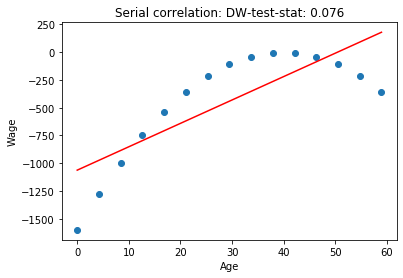

In [46]:
from statsmodels.stats.stattools import durbin_watson
residuals = sm.OLS(y,x).fit().resid
dw_test= durbin_watson(residuals)
if dw_test<1:
    print('Evidence of POSITIVE serial correlation: DW-test stat {:.3f}'.format(dw_test))
elif dw>2:
    print('Evidence of NEGATIVE serial correlation: DW-test stat {:.3f}'.format(dw_test))
else: 
    print('No evidence of serial correlation: DW-Test stat {:.3f}'.format(dw_test))

x = np.linspace(0, 80, 20)[:15]
y = -(x-40)**2

#Using user created function to graph regression
graph_reg(x,y)

plt.title('Evidence of serial correlation: DW-test-stat: {:.3f}'.format(dw_test))
plt.ylabel('Wage')
plt.xlabel('Age')
plt.show()

#### 3.6.1.2 Python example: Durbin watson & serial correlation

DW close to 0 positive serial correlation.
DW close to 4: negative serial correlation.


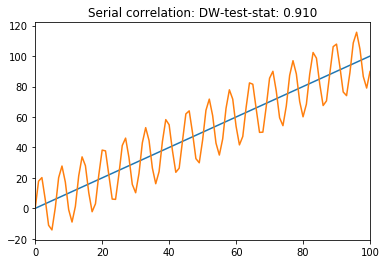

In [48]:
print('DW close to 0 positive serial correlation.') 
print('DW close to 4: negative serial correlation.')

x= list(range(0,101))
y=x
y1= 20*np.sin(y)+x

residuals = sm.OLS(y1,x).fit().resid
dw_test= durbin_watson(residuals)

plt.plot(x,y)
plt.plot(x,y1)
plt.title('Serial correlation: DW-test-stat: {:.3f}'.format(dw_test))
plt.margins(x=0)
plt.show()

## 3.7 Homoskedasticity vs Heteroskedasticity:

### Homoskedastic errors:
$Var(u_i|x_i)=\sigma^2$

### Heteroskedastic errors:
$Var(u_i|x_i)=F(x_i)$

### Examples of heteroskedasticity:
- $\text{wage}= \alpha+\text{education}\beta+ u$
    - Where $var(u|\text{wage})=\sigma^2\text{income}\neq0$
    - This is because those with higher levels of education have more variance in income than those with lower.
        - Think investment bankers vs. teachers wage differential despite similar levels of education.
        - This contrast compares with highschool graduates which generally have similar income levels
        
### Heteroskedasticity in matrix form

$var(u_i|x_i)= \sigma^2x_i^2\\
Cov(u_i u_j|x_ix_j)=0$

$E\Bigg[\begin{bmatrix} u_1^2 & u_2, u_2 & \cdots & u_1 u_n \\ 
u_1, u_2 & u_2^2 & \ddots & \vdots \\ 
\cdots & \cdots & \cdots &  u_n^2\end{bmatrix}\Bigg]|X\\
=\begin{bmatrix} \sigma^2x_1^2 & \cdots & \cdots & 0 \\ 
0& \sigma^2x_2^2 & \ddots & \vdots \\ 
0 & 0 & \sigma^2x_3^2 & \cdots \end{bmatrix}\\
= \sigma^2 \Omega$

### Variance in matrix form


$y = x\beta+u \\
var(y|x) =\sigma^2 \Omega$

- Using $Var(AX)= A Var(x)A\prime$

$$\hat\beta = (x\prime x)^{-1}x\prime y\\
Var(\hat\beta|x)= (x\prime x)^{-1}x\prime \ \ Var(y|x)x(x\prime x)^{-1}$$
### $$=\sigma^2(x\prime x)^{-1}x\prime\Omega x(x\prime x)^{-1}$$

Note: the variance is different than homoscedastic:
- $Var(\hat\beta|hetero)>Var(\hat\beta|homo)$




##### Review: If we assume homoscedastic area we replace $\Omega$ with I(identity matrix) below:

$Var(\hat\beta|x)= (x\prime x)^{-1}x\prime x(x\prime x)^{-1}\\
=\sigma^2(x\prime x)^{-1}$

Reference: Lambert, Ben


### 3.7.1 Python example: visualize heteroskedasticity

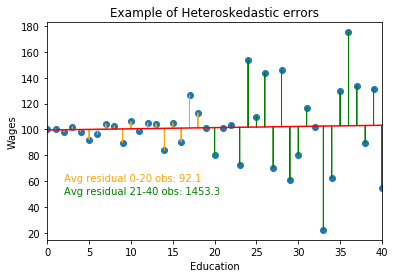

In [49]:
np.random.seed(4)
homo = np.random.normal(loc=100, scale=np.arange(0,41))
x = np.linspace(0,40,41)

intercept = np.polyfit(x,homo, deg=1)[1]
slope = np.polyfit(x,homo, deg=1)[0]

best_fit = intercept+(slope*x)
residual_graph = -(homo-best_fit)
residual = (homo-best_fit)**2
plt.scatter(x,homo)
plt.plot(x, best_fit, color='red')

for i in range(0,21):
    plt.arrow(x[i], homo[i], 0, residual_graph[i], head_width=0.05, head_length=0.1, color='orange')
for i in range(20,41):
    plt.arrow(x[i], homo[i], 0, residual_graph[i], head_width=0.05, head_length=0.1, color='green')

    
plt.annotate("Avg residual 0-20 obs: "+str(round(np.mean(residual[:21]),1)), xy=(2, 60), xytext=(2, 60), color='orange')
plt.annotate("Avg residual 21-40 obs: "+str(round(np.mean(residual[21:]),1)), xy=(2, 50), xytext=(2, 50), color='green')


plt.margins(x=0)
plt.xlabel('Education')
plt.ylabel('Wages')
plt.title('Example of Heteroskedastic errors')
plt.show()

### 3.7.2 Python example: visualize heteroskedasticity

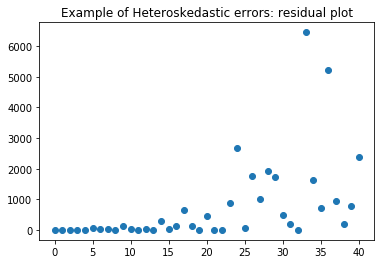

In [50]:
plt.scatter(x, residual)
plt.title('Example of Heteroskedastic errors: residual plot')
plt.show()

### 3.7.3 Goldfeld-Quant test for heteroscedasticity

$$F = \frac{\sum^{N2}_{i=1}\hat u^2/N_2}{\sum^{N1}_{i=1}\hat u^2/N_1}= F_{DF1=N2, DF2=N1}\\
H_0: \text{Homoscedastic errors}$$

### 3.7.3.1 Python Example: Goldfeld-Quant test 

In [83]:
#Generate data
np.random.seed(4)
homo = np.random.normal(loc=100, scale=np.arange(0,41))
x = np.linspace(0,40,41)
results = sm.OLS(homo,x).fit()
import statsmodels.stats.api as sms
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
pd.compat.lzip(name, test)

if pd.compat.lzip(name, test)[1][1]>.05:
    print('Fail to reject GQ test: F-test p-value {:.4f}>.05'.format(pd.compat.lzip(name, test)[1][1]))
    print("Thus we have evidence of heteroscedasticity")
else:
    print('Reject, thus we have evidence of homoscedasticity')

Fail to reject GQ test: F-test p-value 0.7888>.05
Thus we have evidence of heteroscedasticity


### 3.7.4 Breusch Pagan test for heteroscedasticity

$y=\alpha+\beta_1x_1+\beta_2x_2+\cdots+\beta_px_p+u$

- If any of $\delta$ are different than zero other than $\delta_0$ then there is heteroscedasticity
    - $\hat u^2 = \delta_0+\delta_1x_1+\delta_2x_2+\delta_px_p$
    - $H_0=\delta_1=\delta_2=\delta_p=0$
    - $H_1=\delta_i\neq0$
    
Reference: Lambert, Ben

### 3.7.4.1 Python Example: Breusch Pagan test 

In [72]:
residuals = results.resid
test= sms.het_breuschpagan(residuals, results.model.exog)
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
if pd.compat.lzip(name, test)[3][1]<.05:
    print('Reject null hypothesis of BP-F test: {:.4f}<.05'.format(pd.compat.lzip(name, test)[3][1]))
    print("Thus we have evidence of heteroscedasticity")
else:
    print('Fail to reject-null, no evidence of heteroscedasticity')

Reject null hypothesis of BP-F test: 0.0019<.05
Thus we have evidence of heteroscedasticity


### 3.7.5 White test for heteroscedasticity

- Can account for non-linearities and relationship between variables

$y=\alpha+\beta_1x_1+\beta_2x_2+\cdots+\beta_px_p+u\\
\hat u^2 = \delta_0+\delta_1x_1+\cdots+\delta_px_p+\gamma_1x_1^2+\cdots+\gamma_p x_p^2+\eta_1x_1x_2+\cdots$

- The model above require many degrees of freedom, making our statistical test less powerful
- Instead we use the following model

$$\hat u^2 = \delta_0+\delta_1\hat{y}+\delta_2\hat{y}^2\\
H_0: \delta_1=\delta_2=0 \\
\text{F test, if we reject there is hetero}$$

Reference: Lambert, Ben

### 3.7.6 Python example: Graph with diaganostic tests


Reject BP-test null with F-stat p-value 0.002
Fail to reject null Goldfeld-Quant with F-stat p-value 0.789
Rejecting BP and failing to reject GQ test indicates our sample has heteroskedasticity


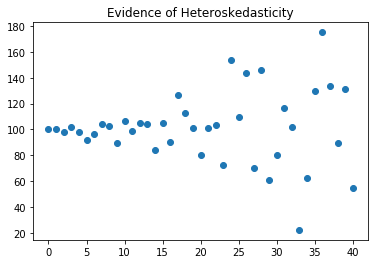

In [73]:
np.random.seed(4)
homo = np.random.normal(loc=100, scale=np.arange(0,41))
x = np.linspace(0,40,41)

def heteroskedasticity(x, y):
    results= sm.OLS(y,x).fit()
    residuals = results.resid
    exog = results.model.exog
    
    if sms.het_breuschpagan(residuals, exog)[3]<.05:
        print('Reject BP-test null with F-stat p-value {:.3f}'.format(sms.het_breuschpagan(residuals, exog)[3]))
    if sms.het_goldfeldquandt(residuals, exog)[1]>.05:
        print('Fail to reject null Goldfeld-Quant with F-stat p-value {:.3f}'.format(sms.het_goldfeldquandt(residuals, exog)[1]))
    if sms.het_goldfeldquandt(residuals, exog)[1]>.05 and sms.het_breuschpagan(residuals, exog)[3]<.05:
        print('Rejecting BP and failing to reject GQ test indicates our sample has heteroskedasticity')
        plt.title('Evidence of Heteroskedasticity')
    else:
        plt.title('No-evidence of heteroskedasticity')
    plt.scatter(x, y)
    plt.show()
#Run the above function
heteroskedasticity(x, homo)


## 3.8 Perfect collinearity

- There is an exact relationship between squarefoot and square meters 
- So we would have perfect collinearity and our regression model would not work. 

$\text{House price}_i = \alpha + \beta_1\text{squarefoot}_i+\beta_2\text{squaremeters}_i+u_i$

#### Multi-collinearity

$\text{Company sales}_i = \alpha + \beta_1\text{Tv_adverts}_i+\beta_2\text{Radio_adverts}_i+u_i$

- We could have a high $R^2$ but $\beta_1, \beta_2$ could be insignificant 
- This is because they are co-llinear and it will be difficult to determine the effect of each.

Reference: Lambert, Ben

### 3.8.1 Python Example: Perfect collinearity

In [74]:
x, y = make_regression(n_samples=100, n_features=2, noise=2, effective_rank=2, bias=0)
results = sm.OLS(y,x).fit()

np.linalg.cond(results.model.exog)

1.156049178359001

## 3.9 Normality


- There is not a hard rule as to which test should be used. Shapiro-Wilk may be used with small sample sizes of less than 50, whereas Kolmogorov is used for larger samples.

- Sometimes Jarque-Bera is not sensitive enough to fat tails.

- Using all tests can provide consensus as to whether our data follows the normal distribution

### 3.9.1 Testing for normality
1. Jarque-Bera 
$$JB= \frac{N}{6}(S^2+\frac{1}{4}(K-3)^2)= H_o:x^2_2$$

2. Shapiro-Wilk

3. Kolmogorov-Smirnov

Reference: Lambert, Ben

### 3.9.2 Python example: Jarque-Bera

A general rule of thumb: 
- 1 rejects the null that the data is normally distributed
- 0 indicates the data is normally distributed

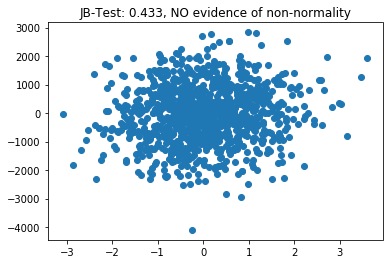

In [90]:
x, y = make_regression(n_samples=1000, n_features=1, noise=1000, bias=10)
results = sm.OLS(y,x).fit()

name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
pd.compat.lzip(name, test)
plt.scatter(x,y)
if test[0]>1:
    plt.title('JB-Test: {:.3f}, evidence of non-normality'.format(test[0]))
else:
    plt.title('JB-Test: {:.3f}, NO evidence of non-normality'.format(test[0]))


plt.show()

## 3.10 F-statstic

- If one of the variables is significant then it means that jointly the varaibles are also significant


$y=\alpha+\beta_1x_1+\beta_2x_2+\cdots+\beta_px_p\\
H_0: \beta_1=\beta_2=\cdots=\beta_p=0\\
H_1: \beta_i\neq 0$

- Two-tailed test
- Unrestricted regression: From full model calculate SSR=$\sum^N_{i=1} \hat u_i^2$
- Restricted regression: From this model $Y=\alpha$ calculate SSR

$$F= \frac{SSR_{\text{Restricted}}-SSR_{\text{Unrestricted}}/(P)}{SSR_{\text{Unrestricted}}/(N-P-1)}$$

- If F is large we can reject the Null hypothesis that are model is jointly non-significant
- F-table is different than T-table with 2 DF
    - $F-DF_1$= is the p value from our numerator
    - $F-DF_2$ = N-P-1 is the denominator
    - Reject if $F>F_{Critical value}$


### Using F-stat to compare insignificant variables in models to significant

$y= \alpha+\beta_1+\beta_2+\beta_3$
- Run regression and find that $\beta_1$ is only signficant variable
- We can then do the following F-test to see whether other variables are jointly insigificant
- Our null is different than first example

$H_0=\beta_2=\beta_3=0$

## 3.11 Errors: population vs. sample


### Population error
- $\text{wage}= \alpha+\beta_1\text{education}+\beta_2\text{ability}+ u$
    - Investment banker (population error u>0) vs. University professor (population error u<0)

### Sample
- $\text{wage}= \alpha+\beta_1\text{education}+\beta_2\text{ability}+ u$
    - $E[\hat u]\neq u$


# 4. Regression interpretation

### 4.1. Hypothesis testing in linear regression

$N \rightarrow \infty \Rightarrow \hat\beta- N\Big(\beta_{\text{True}}, function(\sigma^2)\Big)$

Even though we do not know population $\sigma^2$ we can use following calculation to generate our distribution
$$\text{T-test} = \frac{\hat\beta-\beta}{S.E.(\hat\beta)}$$

$H_0: \beta=0\\
H_1: \beta\neq0$


- If we want to test whether $\beta$ is different than 1

$H_0: \beta=1\\
H_1: \beta\neq1$

$$t=\frac{\text{Coefficient}-(-1)}{\text{Standard-error}}$$



## 4.2 Dummy variables

### 4.2.1 Simple dummy
$wage = \alpha+\beta_1\text{Male}+\beta_2\text{education}$

- Interpretation of the male coffecient is the wage premium (or discount) of males compared to females
- Because women tend to earn less than men this coefficient would expected to be positive for males.

### 4.2.2 Interaction dummy

$wage = \alpha+\beta_1\text{Male}+\beta_2\text{education}+\beta_3\text{Male,education}$

- $\beta_2$ is the return of education for females
- $\beta_3$ is the return of education for males
- Allows for a different marginal return (slope) for education between the sexes 

### 4.2.3 Interaction dummy with continuous variables

$\text{sales}_t= \alpha +\beta_1\text{Widget_Price}+\beta_2\text{Adverts}+\beta_3 \text{Widget_Price, Adverts}$

- $\beta_3$ is a way to see the interaction between price and adverts.
- The effect of advertising for a high price product could have a higher return because consumers have to know how it is different in order to buy

## 4.3 Lagged dependent variables

$s_{t} = \alpha + \beta_0 A_t+\beta_1 A_{t-1}+\beta_2 A_{t-2}+\gamma s_{t-1}+\varepsilon_t$

- Including $\gamma s_{t-1}$ we are controlling for omitted factors
- If a product is addictive (ciggareates sales) the amount of cig sales last week will impact this week

$\bar A \rightarrow A_t+1\\
\bar S \rightarrow S \prime$:

$\bar S = \alpha + \beta_1 \bar A+\beta_2 \bar A + \gamma \bar s\\
\bar S(1-\gamma)= \alpha +\bar A(\beta_1+\beta_2)\\
\bar S= \frac{\alpha}{1-\gamma}+ \frac{\beta_1+\beta_2}{1-\gamma}\bar A$

- The coefficient on $\frac{\beta_1+\beta_2}{1-\gamma}$ is the long run effect of the permamnet increase of advertising of 1-unit

Temporary effect:
$A_t \rightarrow A_t+1\\
t=0: \beta_1\\
t=1: \beta_2+\gamma\beta_1\\
t=2: (\beta_2+\gamma\beta)\gamma\\
t=3: (\beta_2+\gamma\beta)\gamma^2$

## 4.4 Levels vs. differences regression

$y_t = \alpha+\beta x_t+\varepsilon_t\\
\Delta y_t = \delta\Delta x_t+u_t$

- We would think that $\beta$ and $\delta$ would be the same
- It is not the case that if we find a relationship in first difference (FD) then it would imply relationship in levels


#### Proving relationship in levels is related to relationship in FD:

$y_t-y_{t-1} = \alpha+\beta x_t+\varepsilon_t- \alpha-\beta x_{t-1}+\varepsilon_{t-1}\\
\Delta y_t = \beta \Delta x_t +\Delta\varepsilon_t$

Reference: 3.10-4.4 Lambert, Ben

### 4.4.1 Python example: FD vs. Levels

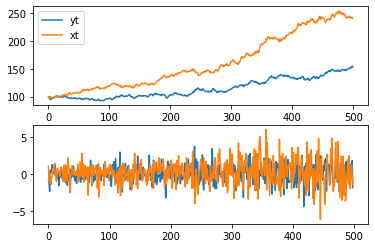

In [3]:
plt.subplot(2,1,1)
rw_drift1 = 100 * np.cumprod(np.random.normal(loc=.001, scale=.01, size=500) + 1)
plt.plot(rw_drift1, label= 'yt')
rw_drift2 = 100 * np.cumprod(np.random.normal(loc=.002, scale=.01, size=500) + 1)
plt.plot(rw_drift2,label= 'xt')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.diff(rw_drift1), label= 'yt')
plt.plot(np.diff(rw_drift2), label= 'yt')
plt.show()

# A. Appendix

## A.1 Degrees of Freedom

For three observations:
- $x_1, x_2, x_3$
- $\bar{x}=2$

#### If we fixed $x_1 and x_2$ then $x_3$ is constrained by the fact we need to have $\bar{x}=2$
- In this case we would have two degrees of freedom
- Thus degrees of freedom is shown to be as (N-1)

### Example: $\sigma^2$

- $\bar{x}=0$
- $S_n^2= \frac{1}{N}(x_1^2+x_2^2+\cdots+x_n^2)$ --Sample variance
- $E[S_n^2]=\frac{N-1}{N}\sigma^2$ Estimation of the population variance using sample variance

Reference: Lambert, Ben

### A.1.1 Python Example: Visualize Degrees of Freedom

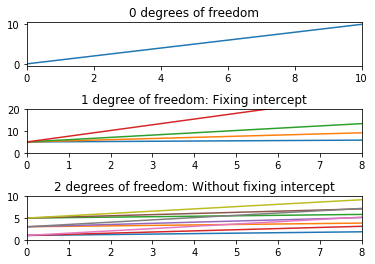

In [21]:
plt.subplots_adjust(hspace = 1)
plt.subplot(3,1,1)
plt.plot(np.linspace(0,10,11))
plt.title('0 degrees of freedom')
plt.margins(x=0)


plt.subplot(3,1,2)
intercept = 5
for i in [2,10,20,50]:
    linear = np.linspace(0,i,20)
    plt.plot(intercept+linear)
plt.xlim([0,8])
plt.ylim([0,20])
plt.margins(x=0)
plt.title('1 degree of freedom: Fixing intercept')

plt.subplot(3,1,3)
for i in [2,5,10]:
    linear = np.linspace(0,i,20)
    for j in [1,3,5]:
        plt.plot(j+linear)
    
plt.xlim([0,8])
plt.ylim([0,10])
plt.margins(x=0)
plt.title('2 degrees of freedom: Without fixing intercept')
plt.show()


## A.2 Python Example: Overfitting-model 

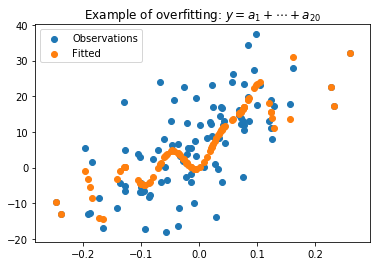

In [22]:
np.random.seed(1)
x, y = make_regression(n_samples=100, n_features=1, noise=10,effective_rank=1, bias=5)
x= pd.DataFrame(x)
for i in range(0,20):
    x['x'+str(i)] = x.iloc[:,[0]]**i
x=x.drop(0, axis=1)
results = sm.OLS(y, x.iloc[:, 1:]).fit()
plt.scatter(x['x1'],y)
plt.scatter(x.x1, results.predict())
plt.title(r'Example of overfitting: $y=a_1+\cdots+a_{20}$')
plt.legend(['Observations','Fitted'])
plt.show()

## A.3 The Gauss-Markov Theorem proof-Matrix form

$y = x\beta + u\\
\hat\beta = (x\prime x)^{-1}x\prime y$

1. $\hat \beta$ is unbiased
2. Variance $\hat \beta$

$\tilde{\beta} = (x\prime x)^{-1}x\prime y+ Dy \tag{1}$

- Substituting y for equation 1

$\tilde{\beta} = (x\prime x)^{-1}x\prime + (x\prime x)^{-1}\prime x u + Dx\beta + Du \tag{2}$

- Taking the $ E[\tilde{\beta}] $

$E[\tilde{\beta}] = \beta + Dx\beta \tag{3}$

- Notes on matrix algebra:
    1. $Var(AX) = AVar(x)A\prime$
    2. $(AB)^{-1}= B^{-1}A^{-1}$
    3. $(A^{-1})^1 = (A^1)^{-1}$

$Var(\tilde{\beta})= C Var(y)C\prime\\
= C\sigma^2 I C\prime\\
= \sigma^2 CC\prime$

Where:
- $C = [(x\prime x)^{-1}x\prime+D]$
- $C\prime = [x(x\prime x)^{-1}+D\prime]$

$Var(\tilde{\beta})= \sigma^2 [(x\prime x)^{-1}x\prime+D] [x(x\prime x)^{-1}+D\prime] \tag{4}$

$=\sigma^2 [(x\prime x)^{-1}  x\prime x  (x\prime x)^{-1}] +[(x\prime x)^{-1}  x\prime D\prime] + Dx (x\prime x)^{-1}+ DD\prime \tag{5}$

$=\sigma^2 [(x\prime x)^{-1}+ \sigma^2 D D\prime \tag{5}$

$Var(\tilde{\beta})=Var(\beta)+ \sigma^2 D D\prime \tag{6}$

- Because D D is a postive semidefinite matrix, the term is in a scalar analago greater or equal to zero
- This proves that the least square estimator is the best linear unbiased estimate

$$Var(\tilde{\beta}) \geq Var(\beta_{ls})$$

Reference: Lambert, Ben

# A4. Visualize OLS: Geometric interpretaiton 

## A4.1 Python Example: One regressor

$y=x\beta_0+ u$
Where: 

$y= \begin{bmatrix}2\\-1 \end{bmatrix}$
$x= \begin{bmatrix}1\\1 \end{bmatrix}$

- Column space is one dimensional line. If we have two independent variables it represents a plane

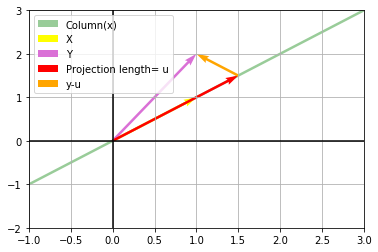

In [3]:
def unit_vector(vector):
    coords_squared = tuple([x**2 for x in vector])
    magnitude = math.sqrt(sum(coords_squared))
    normalized = (1/magnitude)
    unit_vector = np.multiply(vector, normalized)
    return unit_vector
def projection_length(line, x_vec):
    unit = unit_vector(line)
    equation = (np.dot(x_vec,unit))*unit
    return equation
def connect(line, x_vec):
    solution = x_vec-projection_length(line, x_vec)
    return solution
def projection(vecs):
    plt.figure()
    ax = plt.gca()
    line, x = [np.array(i) for i in vecs]
    #Column space of X representation
    ax.quiver(line[0]*-10,line[1]*-10, line[0]*10, line[1]*10, angles='xy',alpha=.4,scale=1,color='green', label='Column(x)')
    #Equation for X
    ax.quiver(0,0,line[0],line[1],angles='xy',scale_units='xy',scale=1, color='yellow', label='X')
    #Equation for Y
    ax.quiver(0,0,x[0],x[1],angles='xy',scale_units='xy',scale=1, color='orchid', label='Y')
    
    #Projection of X on L
    ax.quiver(0,0,projection_length(line, x)[0], projection_length(line, x)[1]
              ,angles='xy',scale_units='xy',scale=1, color='red', label='Projection length= u')
  
    
    #X-(Projection of X on L)
    ax.quiver(projection_length(line, x)[0], projection_length(line, x)[1],connect(line, x)[0], connect(line, x)[1]
              ,angles='xy',scale_units='xy',scale=1, label='y-u', color='orange')
    plt.axvline(color='black')
    plt.axhline(color='black')
    plt.ylim(-2,3)
    plt.xlim(-1,3)
    plt.grid()
    plt.legend(loc='upper left')
    plt.draw()
    plt.show()
y = np.array([1,2])
x = np.array([1,1])
projection([x,y])

## A4.2 Python example: Multiple regressors

[3 1]


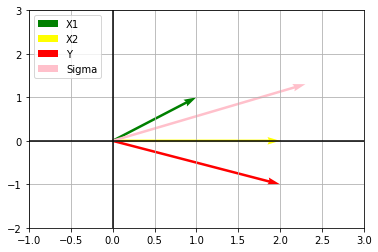

In [4]:
def projections(vecs):
    plt.figure()
    ax = plt.gca()
    y,x1,x2 = [np.array(i) for i in vecs]    
    ax.quiver(0,0,x1[0],x1[1],angles='xy',scale_units='xy',scale=1, color='green', label='X1')
    ax.quiver(0,0,x2[0],x2[1],angles='xy',scale_units='xy',scale=1, color='yellow', label='X2')
    ax.quiver(0,0,y[0],y[1],angles='xy',scale_units='xy',scale=1, color='red', label='Y')
    
    #x2+x1
    x1_x2 = x1+x2
    print(x1_x2)
    #ax.quiver(0,0,x1_x2[0],x1_x2[1],angles='xy',scale_units='xy',scale=1, color='pink', label='X1+X2')
    ax.quiver(0,0,2.30277564, 1.30277564,angles='xy',scale_units='xy',scale=1, color='pink', label='Sigma')

    plt.axvline(color='black')
    plt.axhline(color='black')
    plt.ylim(-2,3)
    plt.xlim(-1,3)
    plt.grid()
    plt.legend(loc='upper left')
    plt.draw()
    plt.show()
    
y = np.array([2,-1])
x1 = np.array([1,1])
x2 = np.array([2,0])
projections([y,x1,x2])